# Calibration of a multipanel detector using single crystal

This script is made to run using the yml file and output of `fit-grains`. The script uses soon-to-be-deprecated detector parameters exported by the GUI and generates a new and complete instrument calibration file.

In practise, you will probably run this script through several times, using the previous result to converge on a solution. The script will **overwrite** the detector parameter files to allow this (both old and new, but the old file spec lacks the chi-tilt optimization.)

## User input here!

In [45]:
# hexrd yaml config file
cfg_filename = 'multiruby1.yml'
block_id = 0 # only change this if you know what you are doing!

# select which orientaion to use (in case of more than one...)
grain_id = 0
override_grain_params = False

# for saturation
int_cutoff = 1.6e4

# load previously saved exclusions
use_saved_exclusions = False
excl_filename = 'exclusion_index_%05d.npy' %grain_id

Ok, that was easy, from here on you shouldn't need to modify anything.

In [46]:
import copy, sys, os

import cPickle

import numpy as np

from scipy.stats import chisquare

import ipywidgets as widgets
from IPython.display import display

import yaml

from scipy.linalg.matfuncs import logm
import scipy.optimize as opt

from hexrd import matrixutil as mutil

from hexrd import config
from hexrd.constants import sqrt_epsf, keVToAngstrom

from hexrd import instrument

# FIXME: distortion kludging
from hexrd.xrd.distortion import GE_41RT # AHHHH!!!!!!
from hexrd.xrd import fitting
from hexrd.xrd import transforms as xf
from hexrd.xrd.transforms import bVec_ref, eta_ref, vInv_ref
from hexrd.xrd import transforms_CAPI as xfcapi

# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline
from matplotlib import pyplot as plt

# Choose a bunch of new matplotlib parameter values
newparams = {'savefig.dpi': 150, 'axes.labelsize': 12, 
             'xtick.labelsize': 6, 'ytick.labelsize': 6}

# Update the global rcParams dictionary with the new parameter choices
plt.rcParams.update(newparams)

# for convenience...
d2r = np.radians(1)
r2d = np.degrees(1)

# Local Functions

In [47]:
# selector for type of obj function return value
return_value_flag = None

# convergence tolerances for the least-squares fit
xtol = 1e-8
ftol = 1e-8

# reference pFlag for one panel.. FIX THIS?
pFlag_ref = np.array(
    [
        1.,
        1., 0., 0., 0.,
        1., 1., 1.,
        1., 0., 1.,
        1., 1., 1., 
        1., 1., 1.,
    ], dtype=bool
)

def geomParamsToInput(wavelength,
                      chi, tVec_s, expMap_c, tVec_c,
                      tiltAngles, tVec_d, 
                      dParams):
    """
    Convenience routine for zipping parameters into single vector
    in proper order
    
    Note that tiltAngle and tVec_d must be LISTS with the same length
    
    dParams is a shitshow... just flattened for all panels for now. 
    
    FIX THIS
    """
    num_panels = len(tiltAngles)
    assert len(tVec_d) == num_panels, "tilts and tvecs must have same length"
    
    p = np.zeros(11 + 6*num_panels)
    
    p[0]  = wavelength
    p[1]  = chi
    p[2]  = tVec_s[0]
    p[3]  = tVec_s[1]
    p[4]  = tVec_s[2]
    p[5]  = expMap_c[0]
    p[6]  = expMap_c[1]
    p[7]  = expMap_c[2]
    p[8]  = tVec_c[0]
    p[9]  = tVec_c[1]
    p[10] = tVec_c[2]

    ii = 11
    for ip in range(num_panels):
        p[ii:ii+6] = np.hstack([
            tiltAngles[ip].flatten(),
            tVec_d[ip].flatten(),
        ])
        ii += 6
    
    # FIXME: FML!!!
    retval = p
    for ip in range(num_panels):
        if dParams[ip] is not None:
            retval = np.hstack([retval, dParams[ip]])
    return retval

def paramsToResults(params, num_panels, distortion=None):
    results = {}
    results['instrument'] = {}
    results['detectors'] = []

    results['instrument']['wavelength'] = params[0] # reassign wlen in this namespace
    results['instrument']['chi'] = params[1]
    results['instrument']['tVec_s'] = params[2:5]
    results['instrument']['expMap_c'] = params[5:8]
    results['instrument']['tVec_c'] = params[8:11]

    ii = 11
    for ip in range(num_panels):
        results['detectors'].append(
            {'tiltAngles':params[ii:ii+3], 
             'tVec_d':params[ii+3:ii+6]}
        )
        ii+=6
    
    if distortion is not None:
        assert len(distortion) == num_panels
        for ip in range(num_panels):
            if distortion[ip][0] is not None:
                ndp = len(distortion[ip][1]) 
                results['detectors'][ip]['dParams'] = params[ii:ii+ndp]
                ii += ndp
            else:
                results['detectors'][ip]['dParams'] = None
            pass
        pass
    return results


def calibrateDetectorFromSX(
    xyo_det, hkls_idx, bMat, wavelength,
    chi, expMap_c,
    tVec_s, tVec_c,
    tiltAngles, tVec_d, 
    vInv=vInv_ref,
    beamVec=bVec_ref, etaVec=eta_ref,
    distortion=None,
    pFlag=pFlag_ref,
    omePeriod=None,
    factor=0.1,
    xtol=sqrt_epsf, ftol=sqrt_epsf,
    ):
    """
    arguments xyo_det, tiltAngles, and tVec_d are LISTS over number of panels
    
    distortion is still hosed...  FIX THIS
    
    p = np.zeros(11 + 6*num_panels)
    
    p[0]  = wavelength
    p[1]  = chi
    p[2]  = tVec_s[0]
    p[3]  = tVec_s[1]
    p[4]  = tVec_s[2]
    p[5]  = expMap_c[0]
    p[6]  = expMap_c[1]
    p[7]  = expMap_c[2]
    p[8]  = tVec_c[0]
    p[9]  = tVec_c[1]
    p[10] = tVec_c[2]
    
    p[11] = tiltAngles[0]
    p[12] = tiltAngles[1]
    p[13] = tiltAngles[2]
    p[14] = tVec_d[0]
    p[15] = tVec_d[1]
    p[16] = tVec_d[2]
    .
    .
    .
    
    """
    npanels = len(xyo_det)
    
    assert len(pFlag) == 11 + 6*npanels
    
    if omePeriod is not None:
        for ip in range(npanels):
            xyo_det[ip][:, 2] = xf.mapAngle(xyo_det[ip][:, 2], omePeriod)

    # distortion is [dFuncs, dParams, dFlags]
    # UGH! FIX THIS
    dFuncs = []
    dParams = []
    dFlags = []
    for ip in range(npanels):
        if distortion[ip] is not None:
            dFuncs.append(distortion[ip][0])
            dParams.append(distortion[ip][1])
            dFlags.append(distortion[ip][2])
        
    pFull = geomParamsToInput(
        wavelength, chi, tVec_s, expMap_c, tVec_c,
        tiltAngles, tVec_d, 
        dParams)

    refineFlag = np.array(np.hstack([pFlag, np.hstack(dFlags)]), dtype=bool)
    pFit       = pFull[refineFlag]
    fitArgs    = (pFull, pFlag, dFuncs, dFlags, xyo_det, hkls_idx,
                  bMat, vInv, beamVec, etaVec, omePeriod)

    results = opt.leastsq(
        objFuncSX, pFit, args=fitArgs,
        factor=factor, xtol=xtol, ftol=ftol
    )

    pFit_opt = results[0]

    retval = pFull
    retval[refineFlag] = pFit_opt
    return retval

def objFuncSX(pFit, pFull, pFlag, 
              dFuncs, dFlags,
              xyo_det, hkls_idx, bMat, vInv,
              bVec, eVec, omePeriod,
              simOnly=False, return_value_flag=return_value_flag):
    """
    """
    npanels = len(xyo_det)
    npts = [len(xyo_det[i]) for i in range(npanels)]
    npts_tot = sum(npts)
    
    dFlag = np.hstack(dFlags)
    refineFlag = np.array(np.hstack([pFlag, dFlag]), dtype=bool)

    # fill out full parameter list; no scaling for now
    pFull[refineFlag] = pFit

    # instrument quantities
    wavelength = pFull[0]
    chi        = pFull[1]
    tVec_s     = pFull[2:5].reshape(3, 1)

    # crystal quantities
    rMat_c = xf.makeRotMatOfExpMap(pFull[5:8])
    tVec_c = pFull[8:11].reshape(3, 1)
    
    # right now just stuck on the end and assumed
    # to all be the same length... FIX THIS
    dParams_all = pFull[-len(dFlag):]
    dParams = []
    ii = 0
    for ip in range(npanels):
        len_these_dps = len(dFlags[ip])
        dParams.append(dParams_all[ii:ii+len_these_dps])
        ii += len_these_dps
        
    ii = 11 # offset to start of panels...
    xy_unwarped = []
    meas_omes = []
    calc_omes = []
    calc_xy = []
    for ip in range(npanels):
        if dFuncs[ip] is not None:
            xy_unwarped.append(
                dFuncs[ip](xyo_det[ip][:, :2], dParams[ip])
            )
        else:
            xy_unwarped.append(xyo_det[ip][:, :2])
            
        meas_omes.append(xyo_det[ip][:, 2])
        
        # get these params for convenience
        gparams = pFull[ii:ii+6]
        
        rMat_d = xf.makeDetectorRotMat(gparams[:3])
        tVec_d = gparams[3:].reshape(3, 1)

        gVec_c = np.dot(bMat, hkls_idx[ip])
        vMat_s = mutil.vecMVToSymm(vInv)                # stretch tensor comp matrix from MV notation in SAMPLE frame
        gVec_s = np.dot(vMat_s, np.dot(rMat_c, gVec_c)) # reciprocal lattice vectors in SAMPLE frame
        gHat_s = mutil.unitVector(gVec_s)               # unit reciprocal lattice vectors in SAMPLE frame
        gHat_c = np.dot(rMat_c.T, gHat_s)               # unit reciprocal lattice vectors in CRYSTAL frame

        match_omes, calc_omes_tmp = fitting.matchOmegas(
            xyo_det[ip], hkls_idx[ip], 
            chi, rMat_c, bMat, wavelength,
            vInv=vInv, 
            beamVec=bVec, etaVec=eVec, 
            omePeriod=omePeriod)

        rMat_s_arr = xfcapi.makeOscillRotMatArray(
            chi, np.ascontiguousarray(calc_omes_tmp)
        )
        calc_xy_tmp = xfcapi.gvecToDetectorXYArray(
                gHat_c.T, rMat_d, rMat_s_arr, rMat_c,
                tVec_d, tVec_s, tVec_c,
        )
        if np.any(np.isnan(calc_xy_tmp)):
            print "infeasible pFull: may want to scale back finite difference step size"
        
        calc_omes.append(calc_omes_tmp)
        calc_xy.append(calc_xy_tmp)
        
        ii += 6
        pass
    
    # return values
    if simOnly:
        retval = [np.hstack([calc_xy[i], calc_omes[i].reshape(npts[i], 1)]) for i in range(npanels)]
    else:
        xy_unwarped = np.vstack(xy_unwarped)
        meas_omes = np.hstack(meas_omes)
        calc_omes = np.hstack(calc_omes)
        calc_xy = np.vstack(calc_xy)
        
        diff_vecs_xy = calc_xy - xy_unwarped[:, :2]
        diff_ome = xf.angularDifference( calc_omes, meas_omes )
        retval = np.hstack([
            diff_vecs_xy,
            diff_ome.reshape(npts_tot, 1)
        ]).flatten()
        if return_value_flag == 1:
            retval = sum( abs(retval) )
        elif return_value_flag == 2:
            denom = npts_tot - len(pFit) - 1.
            if denom != 0:
                nu_fac = 1. / denom
            else:
                nu_fac = 1.
            nu_fac = 1 / (npts_tot - len(pFit) - 1.)
            retval = nu_fac * sum(retval**2 / abs(np.hstack([calc_xy, calc_omes.reshape(npts_tot, 1)]).flatten()))
    return retval



## Setup up detector parameter widget

In [48]:
# read config
cfg = config.open(cfg_filename)[block_id]

# output for eta-ome maps as pickles
working_dir = cfg.working_dir
analysis_name = cfg.analysis_name
analysis_dir = cfg.analysis_dir
analysis_id = "%s_%s" %(analysis_name, cfg.material.active)

# This should use the yaml detector spec, but it appears to include crystal parameters as well:
parfilename = cfg.instrument.parameters
instr_cfg = yaml.load(open(parfilename, 'r'))
instr = instrument.HEDMInstrument(instr_cfg)
num_panels = instr.num_panels

print "INFO: found %d panels in %s" %(num_panels, parfilename)

# orientations
quats_filename = os.path.join(working_dir, 'accepted_orientations_%s.dat' %analysis_id)
spots_filenames = []
for det_id in instr.detectors:
    spots_filenames.append(
        os.path.join(
            analysis_dir, os.path.join(
                det_id, 'spots_%05d.out' % grain_id
            )
        )
    )

# material
matl_list = cPickle.load(open(cfg.material.definitions, 'r'))
matl_names = [matl_list[i].name for i in range(len(matl_list))]
matl_dict = dict(zip(matl_names, matl_list))

matl = matl_dict[cfg.material.active]

# strip plane data
pd = matl.planeData
bMat = np.ascontiguousarray(pd.latVecOps['B']) # hexrd convention; necessary to re-cast (?)
wlen = pd.wavelength * 1.0 # Angstroms

# omega period 
omePeriod = d2r*np.array(cfg.find_orientations.omega.period, dtype=float)

# panel
max_pixel_dim = []
panel_dims = []
for det_id, panel in instr.detectors.iteritems():
    max_pixel_dim.append(max(panel.pixel_size_col, 
                             panel.pixel_size_row))
    panel_dims.append(
        0.5*np.vstack([
            panel.col_dim*np.r_[-1, 1], 
            panel.row_dim*np.r_[-1, 1], 
        ]).T
    )

INFO: found 2 panels in /nfs/chess/user/chess_f2/pokharel-603-1/dexelas_f2_Apr17.yml


In [49]:
# Default detector refinement flags
#   - kludge to not overwrite pFlag_DFLT if already defined/modified
try:
    test = pFlag_DFLT
except NameError:
    pFlag_DFLT = np.hstack(
        [False,
         True, 
         False, False, False, 
         True, True, True,
         True, False, True,
         np.ones(6*num_panels, dtype=bool)
        ]
    )
    
# Set them
pFlag = pFlag_DFLT

# FIXME: distortion kludge
# Hardwired distortion... FIX THIS
dFuncs = []
dParams = []
for det_id, panel in instr.detectors.iteritems():
    if panel.distortion is not None:
        dFuncs.append(panel.distortion[0])
        dParams.append(panel.distortion[1])
    else:
        dFuncs.append(None)
        dParams.append(None)

# Default distortion refinement flags
#   - kludge to not overwrite pFlag_DFLT if already defined/modified
try:
    test = dFlags_DFLT
except NameError:
    dFlags_DFLT = []
    for det_id, panel in instr.detectors.iteritems():
        if panel.distortion is not None:
            dFlags_DFLT.append(np.zeros(6, dtype=bool))
        else:
            dFlags_DFLT.append([])
    
# Set them
dFlags = dFlags_DFLT

## catch bad logic... HARDWIRED FOR 4 panels! FIX THIS
#if np.any(pFlag[[5, 11, 17, 23] and pFlag[-2]:
#    raise RuntimeError, "You've specified refinement of both the Y translation " \
#    "of the detector and crystal, which are correlated"
#dFlag_DFLT = dFlag
#pFlag_DFLT = pFlag
refineFlag = np.array(np.r_[pFlag, np.hstack(dFlags)], dtype=bool)

# Refinement Flags
## Here we have to define all of the refinement flags and scalings for the instrument calibration parameters
### Definitions:
+ the first parameter is the wavelength; **careful!**
        wavelength      (X-ray wavelength in Angstrom)
+ the next **4** describe the rotation (sample) frame
        chi             (canting angle of rotation axis about lab X)
        tVec_s[0]       (rotation axis x-translation; typically 0)
        tVec_s[1]       (rotation axis y-translation; typically 0)
        tVec_s[2]       (rotation axis z-translation; typically 0)
+ the next **6** parameters describe the crystal.  Note the strain (if any) is *fixed*
        expMap_c[0]     (crystal orientation phi*n[0])
        expMap_c[1]     (crystal orientation phi*n[1])
        expMap_c[2]     (crystal orientation phi*n[2])
        tVec_c[0]       (crystal centroid x-translation)
        tVec_c[1]       (crystal centroid y-translation)
        tVec_c[2]       (crystal centroid z-translation)
+ the final **6 x num_panels** describe each panel
        tiltAngles[0]   (tilt about lab X)
        tiltAngles[1]   (tilt about lab Y)
        tiltAngles[2]   (tilt about lab Z -- also panel normal)
        tVec_d[0]       (x-translation; 0 means centered on beam horizontally)
        tVec_d[1]       (y-translation; 0 means centered on beam vertically)
        tVec_d[2]       (z-translation; working distance; values < 0 are downstream)

## Crystal fit parameters

In [50]:
# set parameters for post-fit crystal parameter check...
#   - this mainly makes sense in terms of a calibration standard, since we cant
#     simultaneously fit strain and detector parameters (e.g. distance)
try:
    test = gFlag_DFLT
except NameError:
    gFlag_DFLT = np.array([1, 1, 1,
                           1, 1, 1, 
                           0, 0, 0, 0, 0, 0], dtype=bool)
# grain parameter scalings
gScl  = np.array([1., 1., 1.,
                  1., 1., 1.,
                  1., 1., 1., 0.01, 0.01, 0.01])

## For verifying the crystal parameters (i.e. including strain fit)
### Definitions:
+ the first **6** parameters describe the crystal as above
        expMap_c[0]     (crystal orientation phi*n[0])
        expMap_c[1]     (crystal orientation phi*n[1])
        expMap_c[2]     (crystal orientation phi*n[2])
        tVec_c[0]       (crystal centroid x-translation)
        tVec_c[1]       (crystal centroid y-translation)
        tVec_c[2]       (crystal centroid z-translation)
+ the last **6** parameters describe inverse stretch tensor components (sample frame)
        vInv_s[0]   (inv(V)[0, 0])
        vInv_s[1]   (inv(V)[1, 1])
        vInv_s[2]   (inv(V)[2, 2])
        vInv_s[3]   (inv(V)[1, 2] * sqrt(2))
        vInv_s[4]   (inv(V)[0, 2] * sqrt(2))
        vInv_s[5]   (inv(V)[0, 1] * sqrt(2))

In [51]:
# assign gFlag from checkbox states...  MANUAL FOR NOW; FIX THIS
gFlag = gFlag_DFLT

## Initialize fit parameters

In [52]:
if override_grain_params:
    grain_params = np.loadtxt(os.path.join(analysis_dir, 'grains.out'), ndmin=2)[grain_id, :]
    expMap_c = grain_params[3:6]
    tVec_c = grain_params[6:9]
    vInv_s = grain_params[9:15]
else:
    if instr_cfg['calibration_crystal'].get('grain_id', -1) != grain_id:
        # the cached grain id is not the current grain id
        # start over from default values
        raise RuntimeError
    expMap_c = np.array(instr_cfg['calibration_crystal']['orientation'])
    tVec_c = np.array(instr_cfg['calibration_crystal']['position'])
    vInv_s = np.array(instr_cfg['calibration_crystal']['inv_stretch'])    

chi = instr_cfg['oscillation_stage']['chi']
tVec_s = np.array(instr_cfg['oscillation_stage']['t_vec_s'])

tiltAngles = []
tVec_d = []
for det_id in instr_cfg['detectors']:
    this_detector = instr_cfg['detectors'][det_id]
    tiltAngles.append(np.array(this_detector['transform']['tilt_angles']))
    tVec_d.append(np.array(this_detector['transform']['t_vec_d']))

In [53]:
#List of parameter names for convenience and printing output
pnames = [
    '   wavelength', 
    '          chi',   
    '    tVec_s[0]',   
    '    tVec_s[1]',   
    '    tVec_s[2]',   
    '  expMap_c[0]',   
    '  expMap_c[1]',   
    '  expMap_c[2]',   
    '    tVec_c[0]',   
    '    tVec_c[1]',   
    '    tVec_c[2]']

#
p_initial = np.hstack(
    [
        wlen, 
        chi, tVec_s.flatten(), 
        expMap_c.flatten(), tVec_c.flatten(),
    ]
)
g_initial = np.hstack(
    [
        expMap_c.flatten(), 
        tVec_c.flatten(), 
        vInv_s.flatten()
    ]
)

# load spots tables
hkls = []
xyo_det = []
idx_0 = []
nrefls = []
nrefl = 0
for ip, spots_filename in enumerate(spots_filenames):
    gtable = np.loadtxt(spots_filename) # load pull_spots output table
    valid_reflections = gtable[:, 0] >= 0
    not_saturated = gtable[:, 6] < int_cutoff
    print "INFO: panel %d" %ip
    print "INFO: %d of %d reflections are valid" %(sum(valid_reflections), len(gtable))
    print "INFO: %d of %d valid reflections be are below saturation threshold of %d" \
        %(sum(not_saturated), sum(valid_reflections), int_cutoff)

    idx = np.logical_and(valid_reflections, not_saturated) # select valid reflections
    idx_0.append(idx) # will need this later

    hkls.append(gtable[idx, 2:5].T) # must be column vectors
    xyo_det.append(gtable[idx, -3:][:, [1, 2, 0]]) # these are the cartesian centroids + ome
    xyo_det[ip][:, 2] = xf.mapAngle(xyo_det[ip][:, 2], omePeriod)

    nrefls.append(sum(idx))

    pnames += [
        'tiltAngles_%d[0]' %ip,
        'tiltAngles_%d[1]' %ip,
        'tiltAngles_%d[2]' %ip,
        '    tVec_d_%d[0]' %ip,
        '    tVec_d_%d[1]' %ip,
        '    tVec_d_%d[2]' %ip,
    ]

    p_initial = np.hstack(
        [
            p_initial, 
            tiltAngles[ip].flatten(), 
            tVec_d[ip].flatten(),
        ]
    )
    pass

nrefl = sum(nrefls)

for dp in dParams:
    if dp is not None:
        p_initial = np.hstack([p_initial, np.hstack(dParams)])

for i in range(len(dParams)):
    if dParams[i] is not None:
        for j in range(len(dParams[i])):
            pnames.append('   dParams_%d[%d]' %(i, j))

print "Setup to refine:\n"
for i in np.where(refineFlag)[0]:
    print "\t%s = %1.7e" %(pnames[i], p_initial[i])
print "\nThere are %d total reflections on %d panels\n" %(nrefl, num_panels)
print "\nCalibration Crystal's Hencky Strain Tensor (sample frame):\n"
print logm(np.linalg.inv(mutil.vecMVToSymm(vInv_s)))

INFO: panel 0
INFO: 886 of 1067 reflections are valid
INFO: 771 of 886 valid reflections be are below saturation threshold of 16000
INFO: panel 1
INFO: 886 of 1090 reflections are valid
INFO: 796 of 886 valid reflections be are below saturation threshold of 16000
Setup to refine:

	          chi = 2.2234449e-03
	  expMap_c[0] = 2.7782676e-01
	  expMap_c[1] = 1.4481015e+00
	  expMap_c[2] = -6.2683143e-02
	    tVec_c[0] = -6.9976869e-02
	    tVec_c[2] = -5.3909090e-03
	tiltAngles_0[0] = 2.3428714e-02
	tiltAngles_0[1] = 1.9406648e-02
	tiltAngles_0[2] = -1.5871429e-04
	    tVec_d_0[0] = -1.3871151e+02
	    tVec_d_0[1] = 1.8537494e+00
	    tVec_d_0[2] = -6.4869166e+02
	tiltAngles_1[0] = 1.8862224e-02
	tiltAngles_1[1] = 1.4756760e-02
	tiltAngles_1[2] = 1.5197488e-02
	    tVec_d_1[0] = 1.5052890e+02
	    tVec_d_1[1] = 6.9204855e+00
	    tVec_d_1[2] = -6.5552618e+02

There are 1567 total reflections on 2 panels


Calibration Crystal's Hencky Strain Tensor (sample frame):

[[ 0.  0.  0.]
 [ 0. 

## Check initial guess graphically

Initial goodness of fit:	8.3238e-03


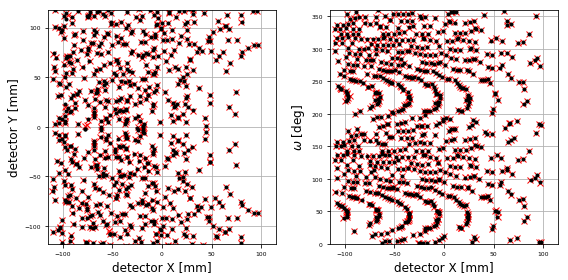

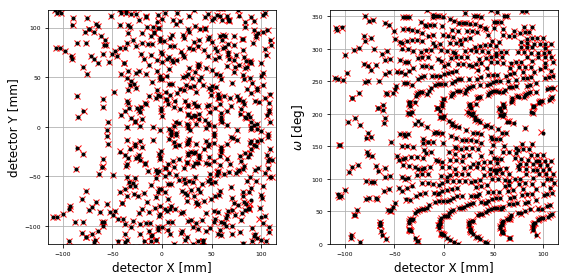

In [54]:
# check out initial residual
xyo_i = objFuncSX(
    p_initial[refineFlag], p_initial, pFlag, dFuncs, dFlags,
    xyo_det, hkls, bMat, vInv_s, 
    bVec_ref, eta_ref, omePeriod, simOnly=True
    )

resd_i = objFuncSX(
    p_initial[refineFlag], p_initial, pFlag, dFuncs, dFlags,
    xyo_det, hkls, bMat, vInv_s, 
    bVec_ref, eta_ref, omePeriod, simOnly=False
    )

nu_fac = 1/(nrefl - sum(refineFlag) - 1.)
chi2_i = nu_fac*sum(resd_i**2/abs(np.vstack(xyo_i).flatten()))
print "Initial goodness of fit:\t%1.4e" %chi2_i

for ip in range(num_panels):
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(8, 4))
    ax[0].plot(xyo_det[ip][:, 0], xyo_det[ip][:, 1], 'rx')
    ax[0].plot(xyo_i[ip][:, 0], xyo_i[ip][:, 1], 'k.')
    ax[0].grid(True)
    ax[0].axis('equal')
    ax[0].set_xlim(panel_dims[ip][0, 0], panel_dims[ip][1, 0])
    ax[0].set_ylim(panel_dims[ip][0, 1], panel_dims[ip][1, 1])
    ax[0].set_xlabel('detector X [mm]')
    ax[0].set_ylabel('detector Y [mm]')

    ax[1].plot(xyo_det[ip][:, 0], r2d*xyo_det[ip][:, 2], 'rx')
    ax[1].plot(xyo_i[ip][:, 0], r2d*xyo_i[ip][:, 2], 'k.')
    ax[1].grid(True)
    ax[1].set_xlim(panel_dims[ip][0, 0], panel_dims[ip][1, 0])
    ax[1].set_ylim(r2d*omePeriod[0], r2d*omePeriod[1])
    ax[1].set_xlabel('detector X [mm]')
    ax[1].set_ylabel(r'$\omega$ [deg]')

    fig.tight_layout()
    fig.show()

# *SKIP TO HERE AND RUN ALL ABOVE*
### If things look pretty good, then we are ready to do the optimization

In [55]:
# fitting
p_refined = calibrateDetectorFromSX(
    xyo_det, hkls, bMat, wlen, 
    chi, expMap_c, 
    tVec_s, tVec_c, 
    tiltAngles, tVec_d, 
    vInv=vInv_s,  beamVec=bVec_ref, etaVec=eta_ref,
    pFlag=pFlag, distortion=zip(dFuncs, dParams, dFlags),  
    factor=1.0, xtol=xtol, ftol=xtol, omePeriod=omePeriod
    )
pref0 = copy.deepcopy(p_refined)

# grab results for convenience
results = paramsToResults(p_refined, num_panels, distortion=zip(dFuncs, dParams, dFlags))
wlen = results['instrument']['wavelength']
tiltAngles = [results['detectors'][i]['tiltAngles'] for i in range(num_panels)]
tVec_d = [results['detectors'][i]['tVec_d'] for i in range(num_panels)]
dParams = [results['detectors'][0]['dParams'] for i in range(num_panels)]

resd_f = objFuncSX(
    p_refined[refineFlag], p_refined, pFlag, 
    dFuncs, dFlags,
    xyo_det, hkls, bMat, vInv_s,
    bVec_ref, eta_ref, omePeriod, simOnly=False
    )
xyo_f = objFuncSX(
    p_refined[refineFlag], p_refined, pFlag, 
    dFuncs, dFlags,
    xyo_det, hkls, bMat, vInv_s, 
    bVec_ref, eta_ref, omePeriod, simOnly=True
    )

Initial chi2:	8.32e-03
Final chi2:	8.34e-03
Refined parameters:
	Name		Initial		Final
	----		-------		-----
	          chi	2.2234449e-03	2.6519014e-03
	  expMap_c[0]	2.7782676e-01	2.7772853e-01
	  expMap_c[1]	1.4481015e+00	1.4481151e+00
	  expMap_c[2]	-6.2683143e-02	-6.2630305e-02
	    tVec_c[0]	-6.9976869e-02	-6.4084629e-02
	    tVec_c[2]	-5.3909090e-03	-5.2926877e-03
	tiltAngles_0[0]	2.3428714e-02	2.2741483e-02
	tiltAngles_0[1]	1.9406648e-02	1.8890675e-02
	tiltAngles_0[2]	-1.5871429e-04	1.4977199e-04
	    tVec_d_0[0]	-1.3871151e+02	-1.3870493e+02
	    tVec_d_0[1]	1.8537494e+00	1.8416224e+00
	    tVec_d_0[2]	-6.4869166e+02	-6.4865666e+02
	tiltAngles_1[0]	1.8862224e-02	1.8935066e-02
	tiltAngles_1[1]	1.4756760e-02	1.4729794e-02
	tiltAngles_1[2]	1.5197488e-02	1.5201630e-02
	    tVec_d_1[0]	1.5052890e+02	1.5053746e+02
	    tVec_d_1[1]	6.9204855e+00	6.9146358e+00
	    tVec_d_1[2]	-6.5552618e+02	-6.5555089e+02




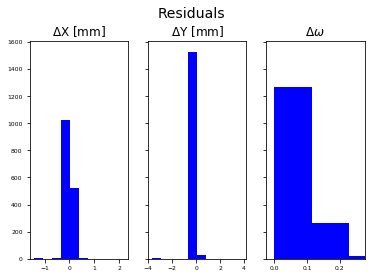

In [56]:
# new style method 2; use an axes array
fig, ax = plt.subplots(1, 3, sharex=False, sharey=True)
fig.subplots_adjust(wspace=0.2)
fig.suptitle("Residuals", fontsize=14, y=1.0)
titles = [r'$\Delta$X [mm]', r'$\Delta$Y [mm]', r'$\Delta\omega$']
for i in range(2):
    ax[i].hist(resd_f.reshape(sum(np.hstack(idx_0)), 3)[:, i], color='b')
    ax[i].set_title(titles[i], fontsize=12)
    #ax[i].set_xlim(-1.1*max_pixel_dim, 1.1*max_pixel_dim)
ax[2].hist(np.degrees(resd_f.reshape(sum(np.hstack(idx_0)), 3)[:, 2]), color='b')
ax[2].set_title(titles[2], fontsize=12)
ax[2].set_xlim(-0.025, cfg.image_series.omega.step+0.025)


chi2_f = nu_fac*sum(resd_f**2/abs(np.vstack(xyo_f).flatten()))
print "Initial chi2:\t%1.2e\nFinal chi2:\t%1.2e\nRefined parameters:" \
    %(chi2_i, chi2_f)
print "\tName\t\tInitial\t\tFinal"
print "\t----\t\t-------\t\t-----"
for i in np.where(refineFlag)[0]:
    print "\t%s\t%1.7e\t%1.7e" %(pnames[i], p_initial[i], p_refined[i])
print "\n"

## At this point we can re-refine after removing outliers
First, define tolerances in terms of pixels (x, y) and frames (omega)

In [57]:
n_pixels_tol = 1.0
n_frames_tol = 1.0

# define difference vectors for spot fits
for ip in range(num_panels):
    x_diff = abs(xyo_det[ip][:, 0] - xyo_f[ip][:, 0])
    y_diff = abs(xyo_det[ip][:, 1] - xyo_f[ip][:, 1])
    ome_diff = r2d*xf.angularDifference(xyo_det[ip][:, 2], xyo_f[ip][:, 2])

    # filter out reflections with centroids more than 
    # a pixel and delta omega away from predicted value
    idx_1 = np.logical_and(
        x_diff <= n_pixels_tol*instr_cfg['detectors'][det_id]['pixels']['size'][1],
        np.logical_and(
            y_diff <= n_pixels_tol*instr_cfg['detectors'][det_id]['pixels']['size'][0], 
            ome_diff <= n_frames_tol*cfg.image_series.omega.step
        )
    )
    
    print "INFO: Will keep %d of %d input reflections on panel %d for re-fit" %(sum(idx_1), sum(idx_0[ip]), ip)
    idx_new = np.zeros_like(idx_0[ip], dtype=bool)
    idx_new[np.where(idx_0[ip])[0][idx_1]] = True
    idx_0[ip] = idx_new
np.savez(excl_filename, idx_0) # output in case you want 'em

INFO: Will keep 543 of 771 input reflections on panel 0 for re-fit
INFO: Will keep 488 of 796 input reflections on panel 1 for re-fit


Initial chi2:	8.32e-03
Final chi2:	2.32e-04
Refined parameters:
	Name		Initial		First		Final
	----		-------		-----		-----
	          chi	2.2234449e-03	2.6519014e-03	2.1908492e-03
	  expMap_c[0]	2.7782676e-01	2.7772853e-01	2.7781923e-01
	  expMap_c[1]	1.4481015e+00	1.4481151e+00	1.4481699e+00
	  expMap_c[2]	-6.2683143e-02	-6.2630305e-02	-6.2686592e-02
	    tVec_c[0]	-6.9976869e-02	-6.4084629e-02	-6.5985393e-02
	    tVec_c[2]	-5.3909090e-03	-5.2926877e-03	-4.5538174e-03
	tiltAngles_0[0]	2.3428714e-02	2.2741483e-02	2.3192403e-02
	tiltAngles_0[1]	1.9406648e-02	1.8890675e-02	1.8874635e-02
	tiltAngles_0[2]	-1.5871429e-04	1.4977199e-04	-4.2516686e-05
	    tVec_d_0[0]	-1.3871151e+02	-1.3870493e+02	-1.3870919e+02
	    tVec_d_0[1]	1.8537494e+00	1.8416224e+00	1.8636890e+00
	    tVec_d_0[2]	-6.4869166e+02	-6.4865666e+02	-6.4864363e+02
	tiltAngles_1[0]	1.8862224e-02	1.8935066e-02	1.8671192e-02
	tiltAngles_1[1]	1.4756760e-02	1.4729794e-02	1.4392520e-02
	tiltAngles_1[2]	1.5197488e-02	1.5201630e-02	1.

(-0.025, 0.275)

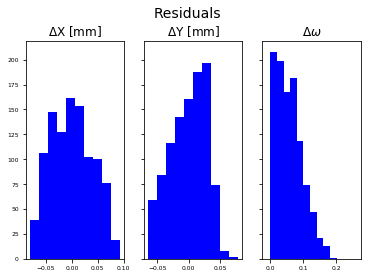

In [58]:
# trim grain table
hkls = []
xyo_det = []
for ip, spots_filename in enumerate(spots_filenames):
    gtable = np.loadtxt(spots_filename) # load pull_spots output table
    hkls.append(gtable[idx_0[ip], 2:5].T) # must be column vectors
    xyo_det.append(gtable[idx_0[ip], -3:][:, [1, 2, 0]]) # these are the cartesian centroids + ome
    xyo_det[ip][:, 2] = xf.mapAngle(xyo_det[ip][:, 2], omePeriod)
    pass

# REFIT!
p_refined = calibrateDetectorFromSX(
    xyo_det, hkls, bMat, wlen, 
    results['instrument']['chi'], results['instrument']['expMap_c'], 
    results['instrument']['tVec_s'], results['instrument']['tVec_c'], 
    tiltAngles, tVec_d, 
    vInv=vInv_s,  beamVec=bVec_ref, etaVec=eta_ref,
    pFlag=pFlag, distortion=zip(dFuncs, dParams, dFlags),  
    factor=1.0, xtol=xtol, ftol=xtol, omePeriod=omePeriod
    )

# grab results for convenience
results = paramsToResults(p_refined, num_panels, distortion=zip(dFuncs, dParams, dFlags))
wlen = results['instrument']['wavelength']
tiltAngles = [results['detectors'][i]['tiltAngles'] for i in range(num_panels)]
tVec_d = [results['detectors'][i]['tVec_d'] for i in range(num_panels)]
dParams = [results['detectors'][0]['dParams'] for i in range(num_panels)]

resd_f = objFuncSX(
    p_refined[refineFlag], p_refined, pFlag, 
    dFuncs, dFlags,
    xyo_det, hkls, bMat, vInv_s,
    bVec_ref, eta_ref, omePeriod, simOnly=False
    )
xyo_f = objFuncSX(
    p_refined[refineFlag], p_refined, pFlag, 
    dFuncs, dFlags,
    xyo_det, hkls, bMat, vInv_s, 
    bVec_ref, eta_ref, omePeriod, simOnly=True
    )

nrefl = len(resd_f) / 3 # updated
nu_fac = 1/(nrefl - sum(refineFlag) - 1.)

chi2_f = nu_fac*sum(resd_f**2/abs(np.vstack(xyo_f).flatten()))
print "Initial chi2:\t%1.2e\nFinal chi2:\t%1.2e\nRefined parameters:" \
    %(chi2_i, chi2_f)
print "\tName\t\tInitial\t\tFirst\t\tFinal"
print "\t----\t\t-------\t\t-----\t\t-----"
for i in np.where(refineFlag)[0]:
    print "\t%s\t%1.7e\t%1.7e\t%1.7e" %(pnames[i], p_initial[i], pref0[i], p_refined[i])
print "\n"

# new style method 2; use an axes array
fig, ax = plt.subplots(1, 3, sharex=False, sharey=True)
fig.subplots_adjust(wspace=0.2)
fig.suptitle("Residuals", fontsize=14, y=1.0)
titles = [r'$\Delta$X [mm]', r'$\Delta$Y [mm]', r'$\Delta\omega$']
for i in range(2):
    ax[i].hist(resd_f.reshape(sum(np.hstack(idx_0)), 3)[:, i], color='b')
    ax[i].set_title(titles[i], fontsize=12)
    #ax[i].set_xlim(-1.1*max_pixel_dim, 1.1*max_pixel_dim)
ax[2].hist(np.degrees(resd_f.reshape(sum(np.hstack(idx_0)), 3)[:, 2]), color='b')
ax[2].set_title(titles[2], fontsize=12)
ax[2].set_xlim(-0.025, cfg.image_series.omega.step+0.025)

### Overwrite material's wavelength, if fit...

In [59]:
if refineFlag[0]:
    mat_list = cPickle.load(
        open(
            cfg.material.definitions, 'r'
            )
        )
    mat_names = [mat_list[i].name for i in range(len(mat_list))]
    mat_dict = dict(zip(mat_names, mat_list))
    active_matl = mat_dict[cfg.material.active]
    active_matl.planeData.wavelength = constants.keVToAngstrom(wlen)
    cPickle.dump(
        mat_list, 
        open(
            cfg.material.definitions, 'w'
            )
        )

# ABOVE HERE IS WHERE THE NEW CALIBRATION IS FINISHED

## Below we check the grain fit

# Write Output

In [60]:
""" WRITE OUT YAML FILE """
instr_cfg['beam']['energy'] = keVToAngstrom(results['instrument']['wavelength'])

instr_cfg['oscillation_stage']['chi'] = float(results['instrument']['chi'])
instr_cfg['oscillation_stage']['t_vec_s'] = results['instrument']['tVec_s'].flatten().tolist()

instr_cfg['calibration_crystal']['grain_id'] = grain_id
instr_cfg['calibration_crystal']['orientation'] = results['instrument']['expMap_c'].tolist()
instr_cfg['calibration_crystal']['position'] = results['instrument']['tVec_c'].tolist()
instr_cfg['calibration_crystal']['inv_stretch'] = vInv_s.tolist()

for ip, det_id in enumerate(instr_cfg['detectors']):
    instr_cfg['detectors'][det_id]['transform']['tilt_angles'] = \
        results['detectors'][ip]['tiltAngles'].tolist()
    instr_cfg['detectors'][det_id]['transform']['t_vec_d'] = \
        results['detectors'][ip]['tVec_d'].tolist()
    if 'distortion' in instr_cfg['detectors'][det_id]:
        instr_cfg['detectors'][det_id]['distortion']['function_name'] = 'GE_41RT' # only choice besides None for now
        instr_cfg['detectors'][det_id]['distortion']['parameters'] = results['detectors'][ip]['dParams'].tolist()
    
with open(parfilename, 'w') as fid:
    fid.write(yaml.dump(instr_cfg))
""" WRITE OUT YAML FILE """

' WRITE OUT YAML FILE '

In [61]:
for ip, det_id in enumerate(instr_cfg['detectors']):
    this_panel = instr_cfg['detectors'][det_id]
    # single panels
    sp_name = det_id.lower()
    with open(sp_name + '.yml', 'w') as fid:
        new_par = {
            'oscillation_stage':{
                'chi':0., 
                't_vec_s':np.zeros(3)
            }, 
            'detector':{'id':det_id,
                        'pixels':{'rows':2048, 'columns':2048, 'size':[0.2, 0.2]}, 
                        'transform':{'tilt_angles':np.zeros(3), 't_vec_d':np.zeros(3)}, 
                        'distortion':{'function_name':None, 'parameters':None},
                        'saturation_level':int_cutoff
                        }, 
            'calibration_crystal':{
                'grain_id':grain_id, 
                'orientation':results['instrument']['expMap_c'].tolist(), 
                'position':results['instrument']['tVec_c'].tolist(), 
                'inv_stretch':np.hstack([np.ones(3), np.zeros(3)]).tolist()
            }
        }
        #
        new_par['oscillation_stage']['chi'] = float(results['instrument']['chi'])
        new_par['oscillation_stage']['t_vec_s'] = results['instrument']['tVec_s'].flatten().tolist()
        # ...chicken and egg problem here, until this format is standard
        new_par['detector']['pixels']['rows'] = this_panel['pixels']['rows']
        new_par['detector']['pixels']['columns'] = this_panel['pixels']['columns']
        new_par['detector']['pixels']['size'] = this_panel['pixels']['size']
        #
        new_par['detector']['transform']['tilt_angles'] = np.array(results['detectors'][ip]['tiltAngles']).tolist()
        new_par['detector']['transform']['t_vec_d'] = results['detectors'][ip]['tVec_d'].flatten().tolist()
        #
        if 'distortion' in instr_cfg['detectors'][det_id]:
            new_par['detector']['distortion']['function_name'] = 'GE_41RT' # only choice besides None for now
            new_par['detector']['distortion']['parameters'] = results['detectors'][ip]['dParams'].tolist()
        #
        fid.write(yaml.dump(new_par))